In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import wrangle_zillow
import model
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

In [2]:
df = wrangle_zillow.wrangle_zillow()
df = wrangle_zillow.handle_missing_zillow_values(df)
df = wrangle_zillow.remove_outliers(df, 3.0, ['bathroom', 'bedroom','square_feet','lot_size','tax_value'])

Using cached data
Shape before handling missing values: (77380, 61)
For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold
Shape after removing nulls: (50906, 53)
Number of observations removed: 4545


In [3]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [4]:
train, validate, test = model.add_features(train, validate, test)

Initially examine correlations between variables and target. No variables showed strong positive or weak correlation.

In [5]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.abs_logerror).sort_values(ascending=False)[2:].head(10)

age                     0.096562
taxdelinquencyflag      0.057685
has_old_heat            0.057519
taxdelinquencyyear      0.052777
is_la                   0.032553
regionidcounty          0.028588
tax_rate                0.026136
bed_bath_ratio          0.025916
land_dollar_per_sqft    0.014003
lot_size                0.013878
dtype: float64

### Which categorical features have statistically significant absolute log errors greater than the overall mean?

In [6]:
overall_mean = train.abs_logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

# print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].abs_logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].abs_logerror, train.abs_logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].abs_logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].abs_logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].abs_logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_abs_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size}).sort_values('difference_from_overall',ascending=False)
# Combine column name and option name
high_log_errors["column_option"] = high_log_errors.column.astype(str)+"-"+(high_log_errors.option.astype(str))

Text(0, 0.5, 'Feature')

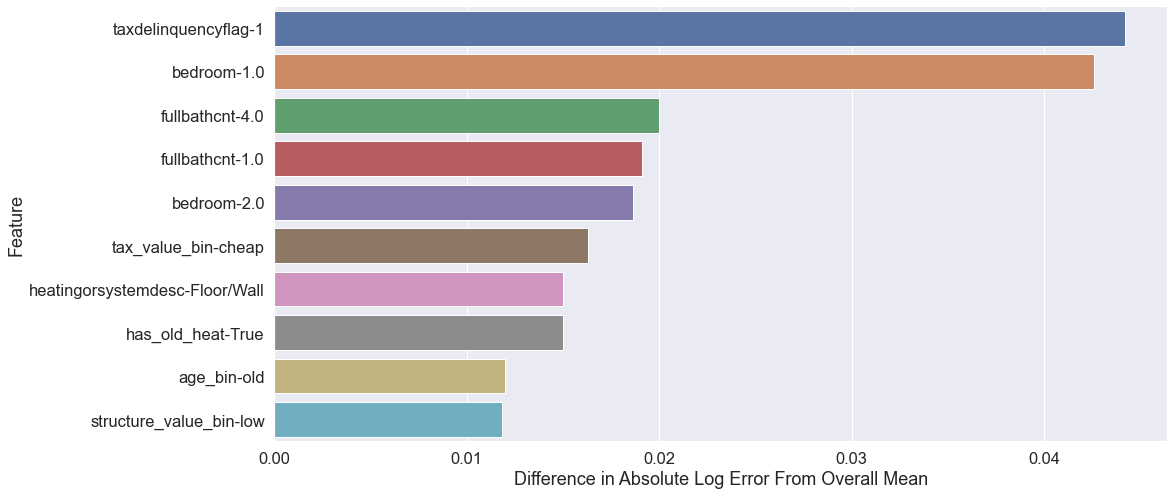

In [7]:
sns.barplot(data = high_log_errors.head(10), y = 'column_option', x = 'difference_from_overall')
plt.xlabel('Difference in Absolute Log Error From Overall Mean')
plt.ylabel('Feature')

### Looking for clusters in the top values:
- Old, Small, low tax value houses with outdated heating systems (age, square feet, tax value, heating system)
- Cheap structure and land valued homes (structure dollar per sqft, land dollar per sqft)
- High full bath counts and high bed to bath houses (fullbathcnt and bed_bath_ratio)
- Tax delinquent, smaller bathrooms counts (2 or less), cheaper tax values

In [8]:
# Scale required columns
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['age','square_feet','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft','fullbathcnt','bed_bath_ratio','bathroom'])

## Cluster on age, square feet, tax value, and old heat

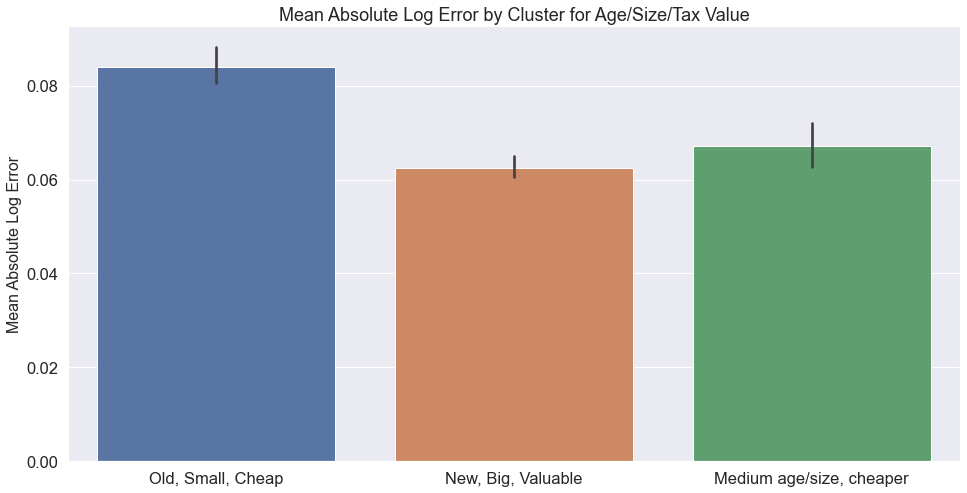

In [45]:
features_to_cluster = ['age_scaled','square_feet_scaled','tax_value_scaled','has_old_heat']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, plots = False)

rename_dict = {0:'Medium age/size, cheaper', 1:'Old, Small, Cheap', 2:'New, Big, Valuable'}
train_scaled = train_scaled.replace({'age_squ_tax_has_cluster':rename_dict})

sns.barplot(data = train_scaled, x = 'age_squ_tax_has_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Age/Size/Tax Value")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.show()

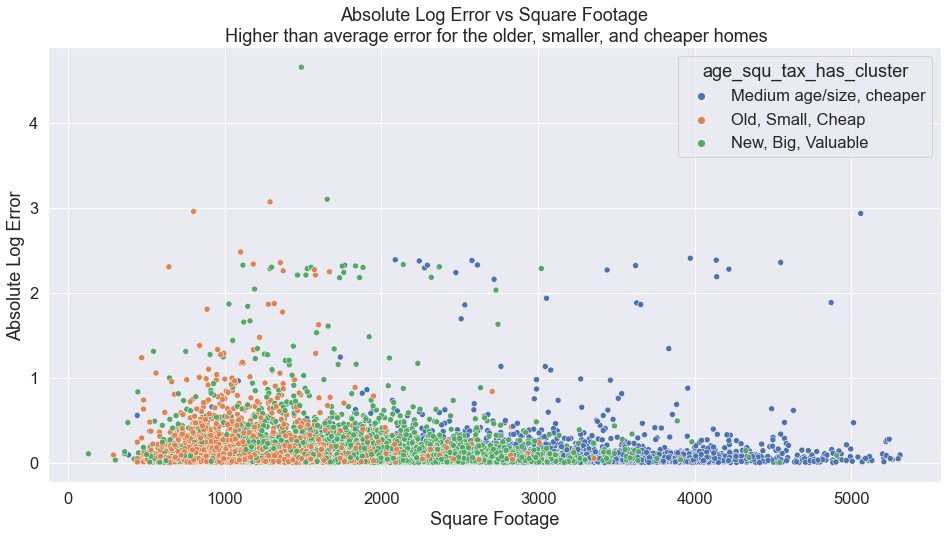

In [42]:
sns.scatterplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='age_squ_tax_has_cluster')
plt.title("Absolute Log Error vs Square Footage\n Higher than average error for the older, smaller, and cheaper homes")
plt.ylabel('Absolute Log Error')
plt.xlabel('Square Footage')
plt.show()

### Three cluster identified as:
- New, Big, High Tax Value, Newer heat
- Old, Small, Low Tax Value, Older heat 
    + This cluster showed statistically significant higher than average absolute log error
- Medium age, Medium size, Lower tax value, Newer heat 
    + This cluster showed statistically significant lower than average absolute log error error 

### Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 

## Cluster on structure and land value and tax delinquency

Text(0.5, 0, '')

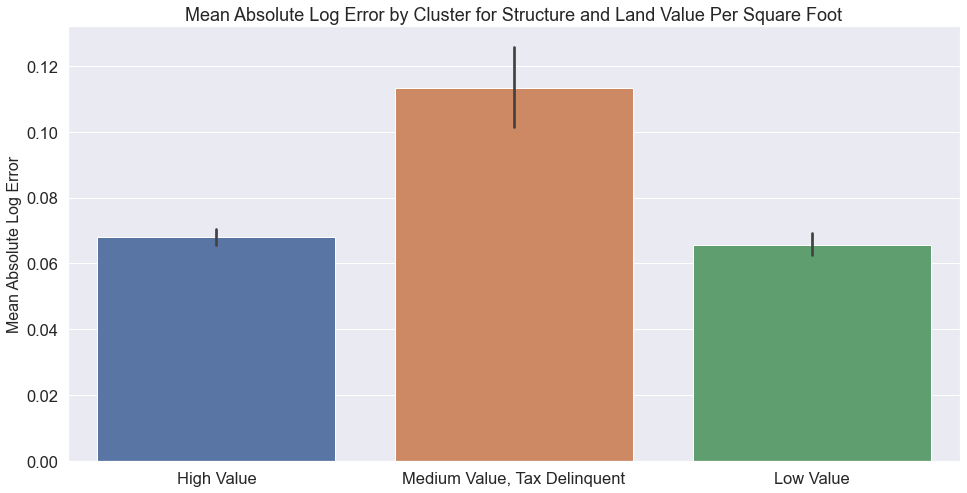

In [43]:
features_to_cluster = ['structure_dollar_per_sqft_scaled','land_dollar_per_sqft_scaled','taxdelinquencyflag']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, cluster_qty = 3, plots=False)

rename_dict = {0:'Low Value', 1:'Medium Value, Tax Delinquent', 2:'High Value'}
train_scaled = train_scaled.replace({'str_lan_tax_cluster':rename_dict}).sort_values(by='structure_dollar_per_sqft')
sns.barplot(data = train_scaled, x = 'str_lan_tax_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Structure and Land Value Per Square Foot")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)

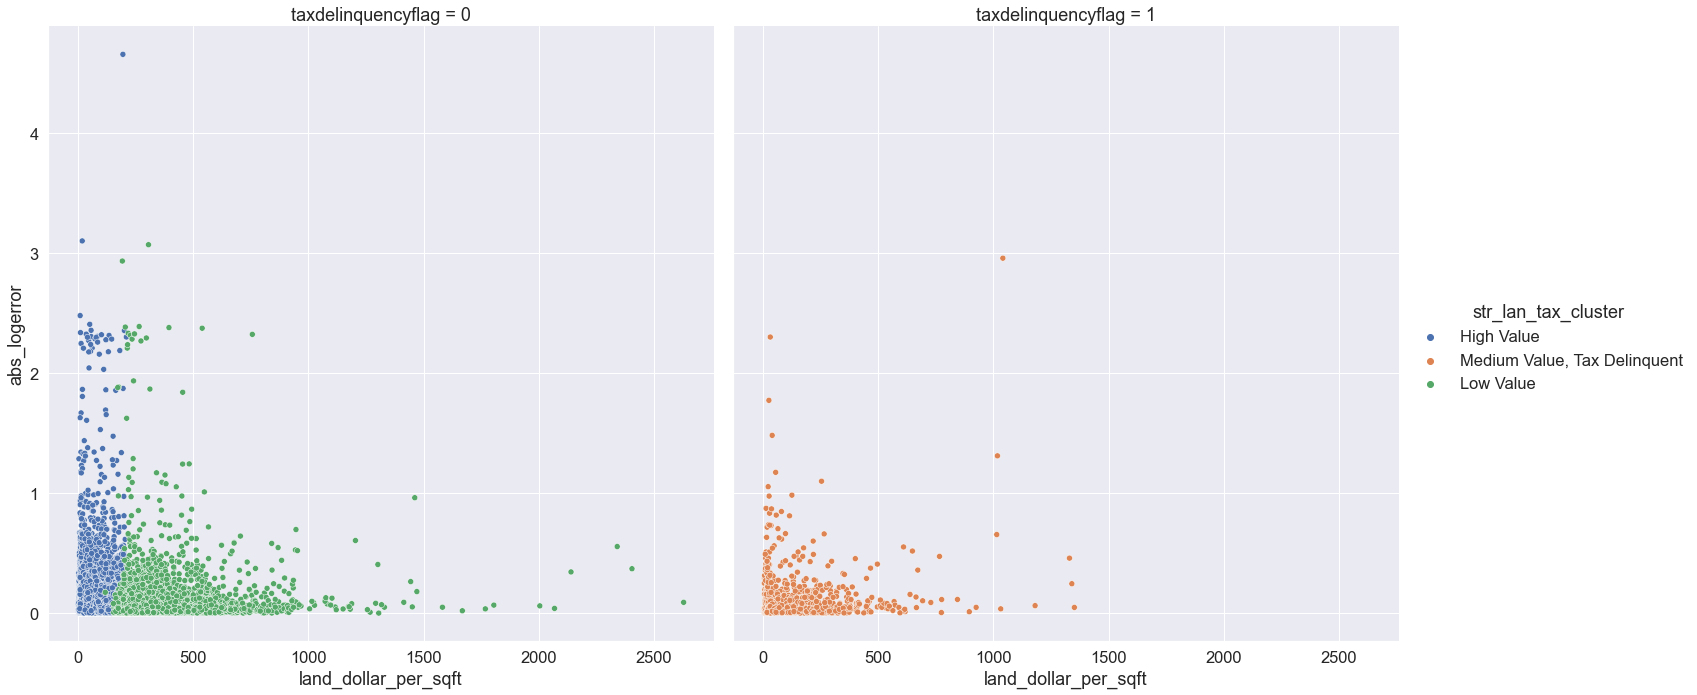

In [44]:
sns.relplot(data = train_scaled, x = 'land_dollar_per_sqft', y='abs_logerror', hue='str_lan_tax_cluster', height = 10, col = 'taxdelinquencyflag')

In [14]:
# train_scaled.groupby('str_lan_tax_cluster').mean()[['structure_dollar_per_sqft','land_dollar_per_sqft','abs_logerror','taxdelinquencyflag']].sort_values('land_dollar_per_sqft',ascending=False)

### Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.

## Cluster on full bath count and bed to bath ratio

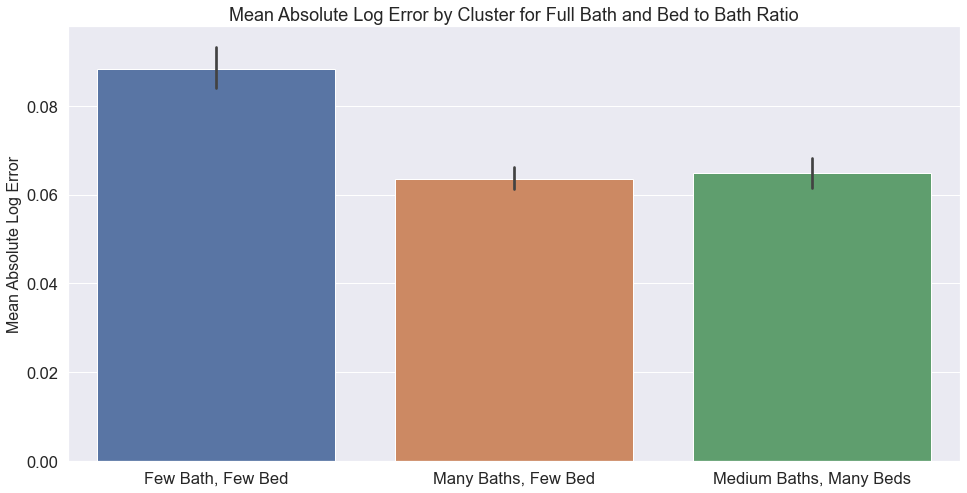

In [47]:
features_to_cluster = ['fullbathcnt_scaled','bed_bath_ratio_scaled']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster, cluster_qty=3, plots=False)

rename_dict = {0:'Many Baths, Few Bed', 1:'Few Bath, Few Bed', 2:'Medium Baths, Many Beds'}
train_scaled = train_scaled.replace({'ful_bed_cluster':rename_dict}).sort_values(by='fullbathcnt')
sns.barplot(data = train_scaled, x = 'ful_bed_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.show()

- Few full baths, low bed to bath ratios
- Medium full baths, Medium bed to bath ratios (number of full baths ~= number of beds)
- Few full baths, high bed to bath ratios
    + statistically significant mean abs log error above overall average

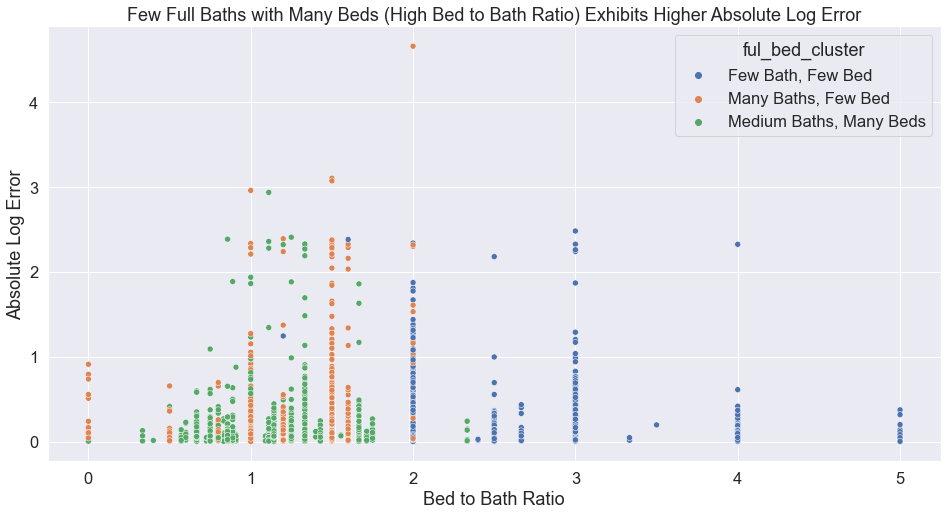

In [46]:
sns.scatterplot(data = train_scaled, x = 'bed_bath_ratio', y='abs_logerror', hue='ful_bed_cluster')
plt.title("Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error")
plt.ylabel('Absolute Log Error')
plt.xlabel('Bed to Bath Ratio')
plt.show()

### Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error

## Cluster by tax delinquency, bathroom, tax values

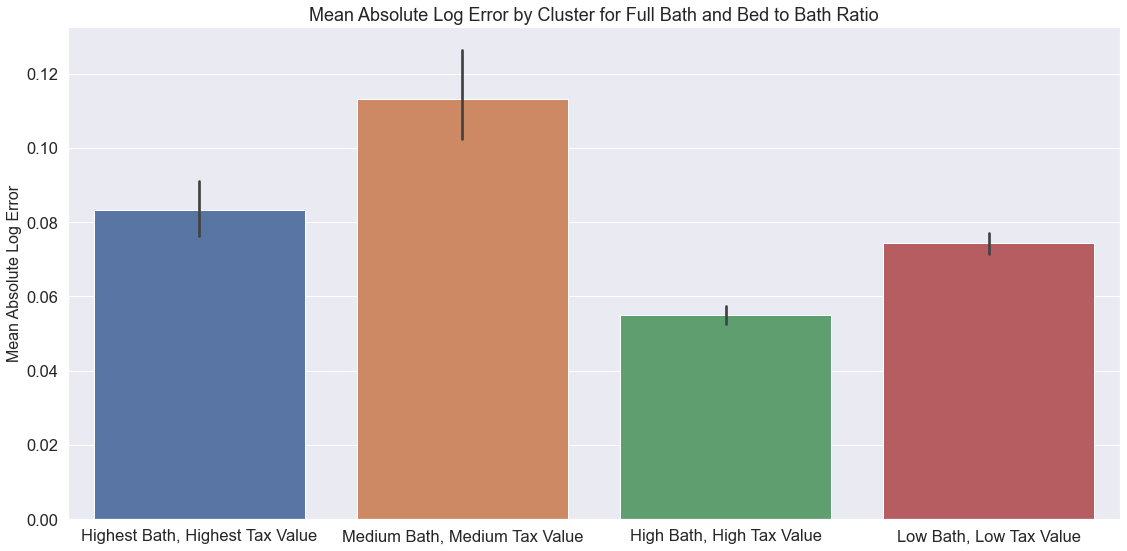

In [72]:
features_to_cluster = ['taxdelinquencyflag','bathroom_scaled','tax_value_scaled']
train_scaled = model.perform_cluster_analysis(train_scaled, features_to_cluster,cluster_qty=4, plots=False)

rename_dict = {2:'Low Bath, Low Tax Value', 3:'Highest Bath, Highest Tax Value', 0:'High Bath, High Tax Value', 1:'Medium Bath, Medium Tax Value'}
train_scaled = train_scaled.replace({'tax_bat_tax_cluster':rename_dict}).sort_values(by='bathroom', ascending=False)
sns.barplot(data = train_scaled, x = 'tax_bat_tax_cluster', y='abs_logerror')
plt.title(f"Mean Absolute Log Error by Cluster for Full Bath and Bed to Bath Ratio")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("", fontsize=16)
plt.tight_layout()

In [73]:
train_scaled.groupby('tax_bat_tax_cluster').mean()[['bathroom','tax_value','taxdelinquencyflag','abs_logerror']].sort_values('bathroom',ascending=False)

,bathroom,tax_value,taxdelinquencyflag,abs_logerror
tax_bat_tax_cluster,,,,
"Highest Bath, Highest Tax Value",3.250352,1.113282e+06,0.0,0.083330
"High Bath, High Tax Value",2.549739,4.763707e+05,0.0,0.054947
"Medium Bath, Medium Tax Value",1.922431,3.758665e+05,1.0,0.113254
"Low Bath, Low Tax Value",1.598068,2.145003e+05,0.0,0.074238


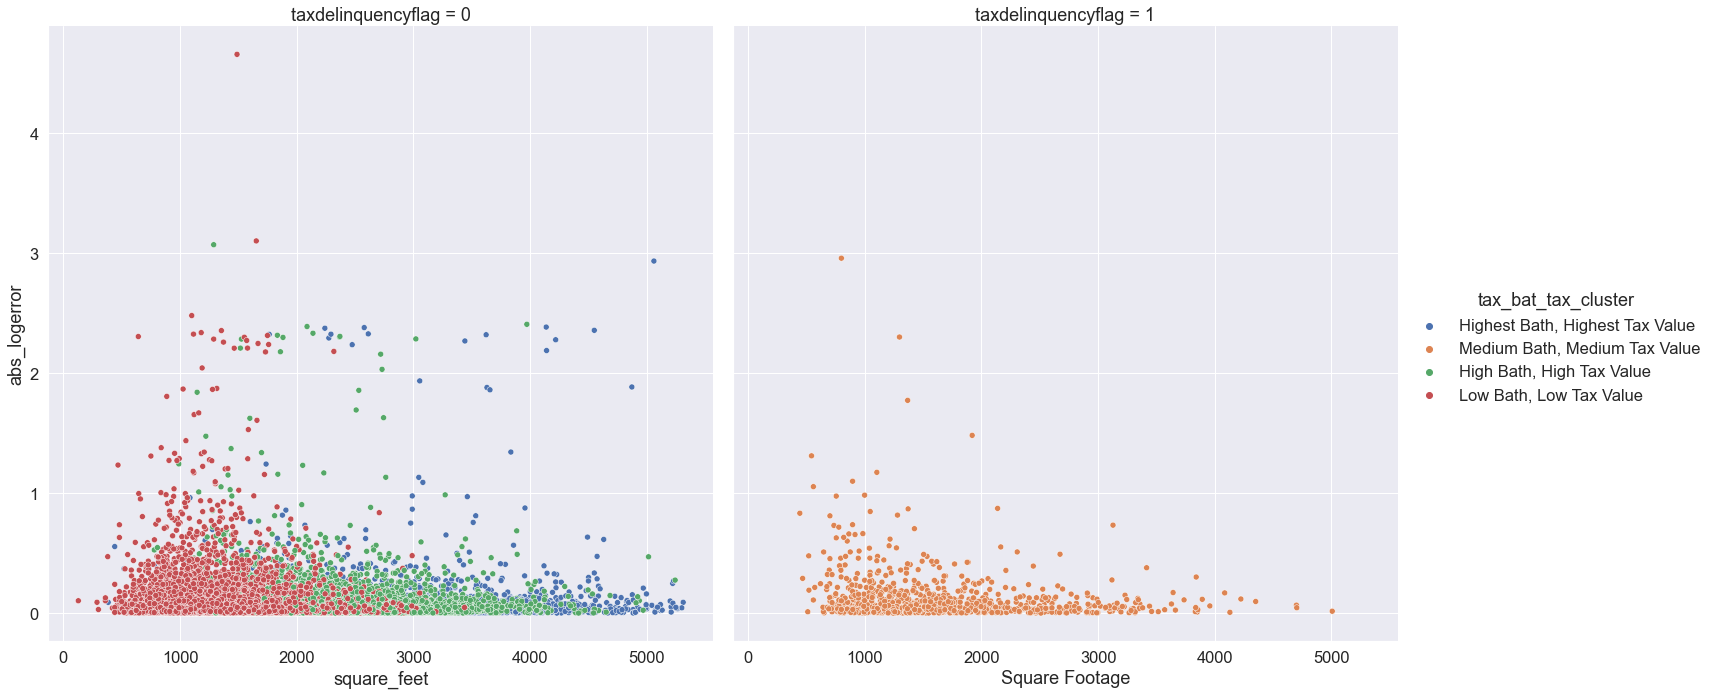

In [62]:
# plt.figure(figsize=(30,8))
sns.relplot(data = train_scaled, x = 'square_feet', y='abs_logerror', hue='tax_bat_tax_cluster', height = 10, col='taxdelinquencyflag')
plt.ylabel('Absolute Log Error')
plt.xlabel('Square Footage')
plt.show()

### Clusters are:
- Low Bath, Low Tax Value
- Medium Bath, Medium Tax Value and tax delinquent
    + Statistically significant higher than average log error 
- High Bath, High Tax Value
    + Statistically significant higher than average log error 
- Highest Bath, Highest Tax Value

### Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Exploration Takeaways:
- Size, age, tax value and tax delinquency are the greatest affect on absolute log error.
- Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 
- Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.
- Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error
- Tax Values and bathroom counts on both high and low ends of the range result in higher log errors. Tax delinquency has a strong effect on log error as originally shown via t-test results.

## Regression Modeling
- Attempt to predict log error based on results from exploration
- Top features for model selection: 
    - age
    - size
    - tax value
    - tax delinquency status
    - bathroom count (correlated with size)

# USE CLUSTERS IN THE MODEL!!!

In [34]:
train_scaled.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

In [21]:
# These are the features that need to be scaled
features_to_scale = ['age','square_feet','bathroom','bedroom','tax_value','land_dollar_per_sqft','structure_dollar_per_sqft', 'bed_bath_ratio']
# These are the features that will be fed into the model based on exploration
columns_to_use = ['age','square_feet','bathroom','bedroom','tax_value','structure_dollar_per_sqft','land_dollar_per_sqft', 'bed_bath_ratio','taxdelinquencyflag',
        'has_old_heat','is_la','is_orange']

to_dummy=['fullbathcnt_bin', 'age_bin','tax_value_bin', 'lot_size_bin',
       'bed_to_bath_bin', 'structure_value_bin', 'land_value_bin']
# Test each county with each regression algorithm
all_results = {}

# Perform scaling
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = model.data_scaling(train, validate, test, to_dummy, features_to_scale, columns_to_use)

rfe_features = model.model_feature_selection(X_train_scaled, y_train, 4)
print(rfe_features)

['bathroom_scaled', 'land_dollar_per_sqft_scaled', 'structure_dollar_per_sqft_scaled', 'bed_bath_ratio_scaled']


In [25]:
# Save results from fitting and predicting to a dictionary
model_results = model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features=rfe_features, show_test = True, print_results = True)

Using Index(['bathroom_scaled', 'land_dollar_per_sqft_scaled',
       'structure_dollar_per_sqft_scaled', 'bed_bath_ratio_scaled'],
      dtype='object')
RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17
RMSE for OLS using LinearRegression
Training/In-Sample:  0.1680995987777757 
Validation/Out-of-Sample:  0.17153154013721597
RMSE for OLS using LarsLasso
Training/In-Sample:  0.16827020271765275 
Validation/Out-of-Sample:  0.17189726668428837
RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  0.1681632636975666 
Validation/Out-of-Sample:  0.17161913483909483
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16772618311470738 
Validation/Out-of-Sample:  0.17190675527341628


In [39]:
print("Percent Improvement above baseline: ",100*((0.168270-0.163634)/.168270))

Percent Improvement above baseline:  2.755095976704107


Text(0.5, 0.98, 'RMSE Results for Top Model (OLS)')

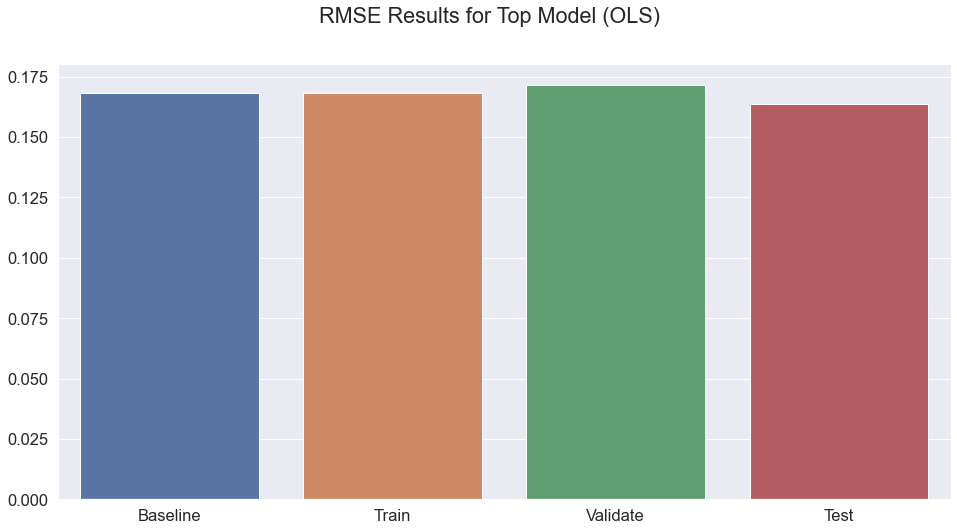

In [33]:
# Plot modeling results for top models

top = model_results.sort_values(by='r2_validate',ascending=False).iloc[2:].head(1)
sns.barplot(x = ['Baseline','Train','Validate','Test'], y = [model_results.loc['log_error_pred_mean']['rmse_train'], top.rmse_train.values[0], top.rmse_validate.values[0],top.rmse_test.values[0]])
# ax[i].set_title(county)
plt.suptitle('RMSE Results for Top Model (OLS)')

## Modeling takeaways:
- The OLS model performed the best based on RMSE validate score, and when evaluated using the test set showed a ~3% improvement for predicting log error over baseline
- Other models were very close in performance to OLS
- The high RMSE and r2 values show that log error cannot be effectively modeled using linear regression using these features and parameters; further refinement work is necessary to improve the model.

# Conclusion

- Based on the key findings demonstrated in this project the Zestimate needs to be improved for homes with the following factors:
    - small size
    - low tax value
    - medium structure and land values
    - older homes
    - high bed to bath ratios
- Homes with tax delinquency show very high log errors relative to the average
    - If the current model uses data from recent tax records then it will need to be adjusted for these homes
- The OLS model performed the best based on RMSE validate score, and when evaluated using the test set showed a ~3% improvement for predicting log error over baseline
- Other models were very close in performance to OLS
- The high RMSE and r2 values show that log error cannot be effectively modeled using linear regression using these features and parameters; further refinement work is necessary to improve the model.
- Older, smaller, and cheaper (tax value) homes have greater than average absolute error. Medium size and age homes have slightly lower average error. 
- Medium structure and land values with tax delinquency result in higher absolute log errors. Higher and lower structure and land values have lower than average log errors.
- Few Full Baths with Many Beds (High Bed to Bath Ratio) Exhibits Higher Absolute Log Error


## Future work:
- Explore other factors that may affect log errors
- Create additional features for modeling
- Perform additional feature engineering work 
- Test additional hyperparameters for the models